In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_color_codes("pastel")

In [2]:
partial_df = pd.read_csv("data/processed/full_dataset.csv",
                         usecols=['order_id', 'reordered', 'product_id'],
                         dtype={'order_id': np.int32,
                                'reordered': np.int8,
                                'product_id': np.uint16})
                         #nrows=10000000)

In [3]:
partial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 3 columns):
order_id      int32
product_id    uint16
reordered     int8
dtypes: int32(1), int8(1), uint16(1)
memory usage: 216.5 MB


## Reordered statistics

In [4]:
reordered_summary = partial_df['reordered'].value_counts()

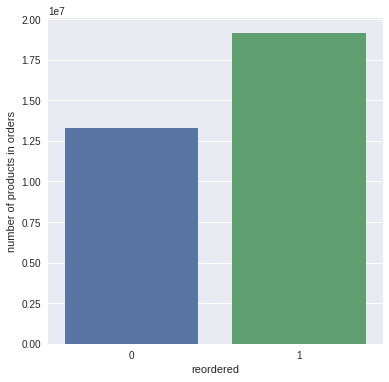

In [6]:
f, ax = plt.subplots(figsize=(6, 6))

sns.barplot(x=reordered_summary.index,
            y=reordered_summary.values)
ax.set_xlabel('reordered')
ax.set_ylabel('number of products in orders')

plt.show()

## Reordered products

In [7]:
product_df = pd.read_csv("data/processed/product_aisle_department.csv",
                         dtype={'product_id': np.uint16,
                                'aisle_id': np.uint8,
                                'department_id': np.uint8})

In [8]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 6 columns):
product_id       49688 non-null uint16
product_name     49688 non-null object
aisle_id         49688 non-null uint8
department_id    49688 non-null uint8
aisle            49688 non-null object
department       49688 non-null object
dtypes: object(3), uint16(1), uint8(2)
memory usage: 1.3+ MB


In [9]:
products_by_reordered = partial_df.groupby(['product_id', 'reordered']).count()
products_by_reordered.columns = ['count']
products_by_reordered = products_by_reordered.reset_index()

In [10]:
products_by_reordered = pd.merge(products_by_reordered, product_df, on='product_id')

In [11]:
products_by_reordered.head()

,product_id,reordered,count,product_name,aisle_id,department_id,aisle,department
0,1,0,716,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,1,1,1136,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
2,2,0,78,All-Seasons Salt,104,13,spices seasonings,pantry
3,2,1,12,All-Seasons Salt,104,13,spices seasonings,pantry
4,3,0,74,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages


## Reordered by aisle

In [12]:
aisles_stats = pd.DataFrame()

aisles_stats['total_purchases'] = products_by_reordered.groupby('aisle')['count'].sum().astype(np.int32)
aisles_stats['total_reordered'] = products_by_reordered.loc[products_by_reordered['reordered'] == 1].groupby('aisle')['count'].sum().astype(np.int32)
aisles_stats['reordered_rate'] = aisles_stats['total_reordered'] / aisles_stats['total_purchases']

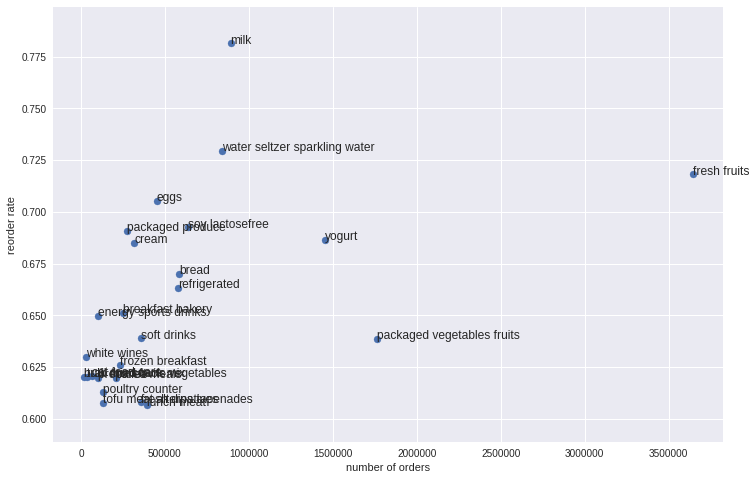

In [15]:
reorder_rate_treshold = 0.6
tmp_df = aisles_stats.loc[aisles_stats['reordered_rate'] > reorder_rate_treshold]


fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(tmp_df['total_purchases'], tmp_df['reordered_rate'])
ax.set_ylabel('reorder rate')
ax.set_xlabel('number of orders')


for i, txt in enumerate(tmp_df.index):
    ax.annotate(txt, (tmp_df['total_purchases'][i], tmp_df['reordered_rate'][i]))

plt.show()

## Most reordered products

In [16]:
reordered_products = products_by_reordered[products_by_reordered['reordered'] == 1]

In [17]:
n = 20
best_selling_reordered_products = reordered_products.sort_values('count', ascending=False).head(n)

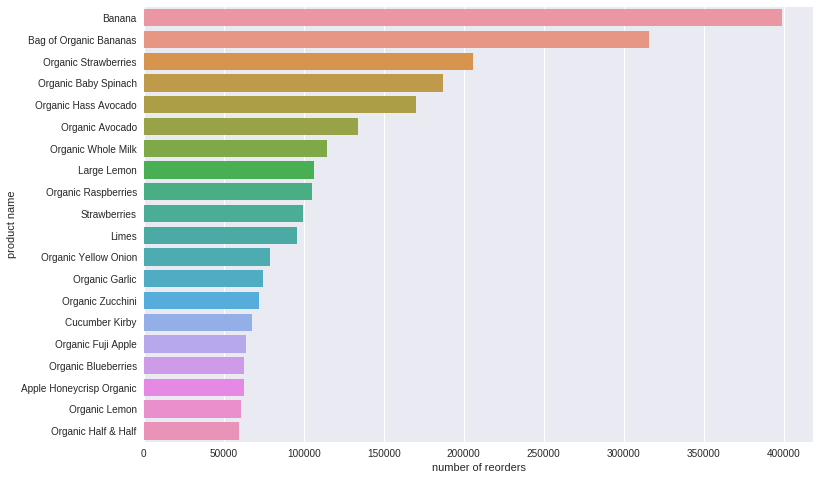

In [18]:
f, ax = plt.subplots(figsize=(12, 8))

sns.barplot(x=best_selling_reordered_products['count'],
            y=best_selling_reordered_products['product_name'])
ax.set_xlabel('number of reorders')
ax.set_ylabel('product name')

plt.show()